In [13]:
from skimage import io, transform
import os
from matplotlib import pyplot as plt
import argparse
from glob import glob
import sys
sys.path.insert(1,r'..\utility')
sys.path.insert(1,r'..\models')
from dataloader import  Mobile_Dataset_RAM, reverse_transform
from loss import loss_l2
from tqdm import tqdm
from albumentations import Compose, Normalize
import albumentations.pytorch as albu_torch
from torch.utils.data import DataLoader
from models import  ResNet18_conv_fc
import torch
import torch.nn as nn
import numpy as np

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# parser=argparse.ArgumentParser()
# parser.add_argument('--dir_data',required=True)
# parser.add_argument('--partition',required=True)
# parser.add_argument('--filepath_model',required=True)
# parser.add_argument('--batchSize', type=int, required=True)
# args = parser.parse_args()
class Args():
    def __init__(self):
        self.dir_data=r'D:\Data\cs-8395-dl\assignment1_data'
        self.partition='validation'
        self.filepath_model = r'D:\Data\cs-8395-dl\model\2020-01-24-00-44-39\2020-01-24-00-44-39_resnet18_best.pt'
        self.batchSize = 1
        
args = Args()
dir_img = os.path.join(args.dir_data,args.partition)
filepaths = glob(os.path.join(dir_img, '*.jpg'))
# print(len(filepaths))
flnames = [os.path.basename(path) for path in filepaths]

filepath_label = os.path.join(args.dir_data, 'labels', 'labels.txt')
with open(filepath_label, 'r') as f:
    label_data = f.readlines()

label_dict={}
for data in label_data:
    name, x, y = data.strip().split(' ')
    label_dict[name]=(float(x),float(y))

aug = Compose([
    # Resize(256,256),
    #            RandomRotate90(),
    Normalize(),
    albu_torch.ToTensorV2()
],
)

Dataset = Mobile_Dataset_RAM(dir_data=dir_img, files=flnames, label_dict=label_dict, transform=aug)
print('number of samples {}'.format(len(Dataset)))
loader=DataLoader(Dataset,batch_size=args.batchSize, shuffle=False)
if 'resnet18' in args.filepath_model:
    model = ResNet18_conv_fc(pretrained=False,bottleneckFeatures=False).to(device)

train_states=torch.load(args.filepath_model)
print('loading model from epoch {}, with criteria {}'.format(train_states['epoch'],train_states['model_save_criteria']))
model.load_state_dict(train_states['model_state_dict'])
_=model.eval()

loading images to RAM


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 384.53it/s]


number of samples 10
loading model from epoch 255, with criteria 0.03317001811180127


In [15]:
model

ResNet18_conv_fc(
  (resnet18_fc_stripped): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

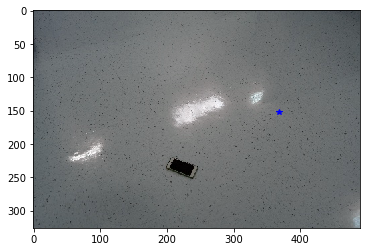

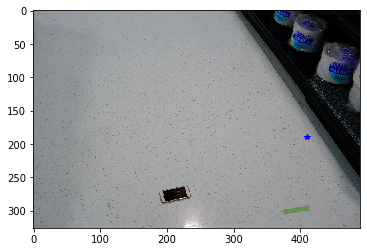

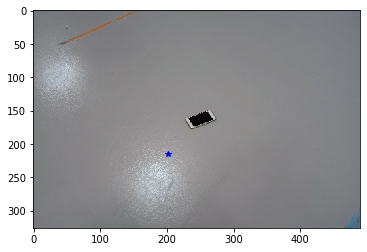

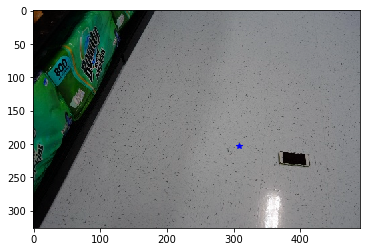

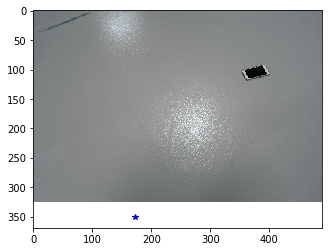

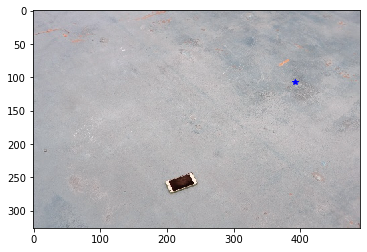

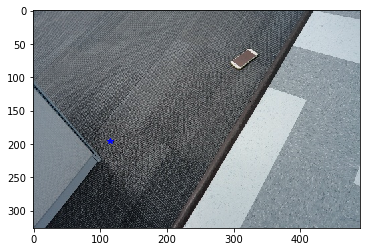

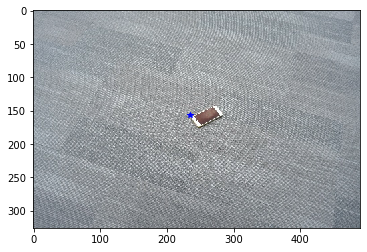

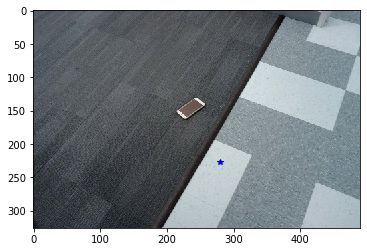

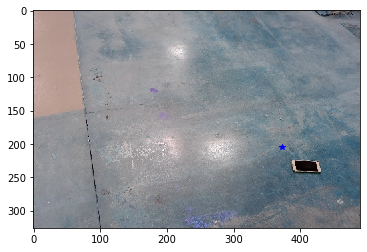

In [18]:
with torch.no_grad():
    for i, sample in enumerate(loader):
        img = sample[0].to(device)
        output = model(img)
        img_r = reverse_transform(img.cpu().squeeze())
        x,y=output.squeeze().cpu().numpy()
        
        plt.imshow(img_r)
        
        plt.plot(y*img_r.shape[1],x*img_r.shape[0],'b*')
        plt.show()


In [9]:
res_last_conv = nn.Sequential(*list(model.children())[:-2])
res_last_conv

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [10]:
# Valid

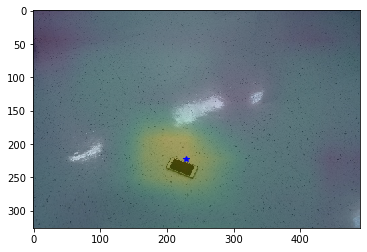

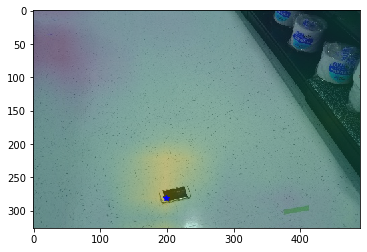

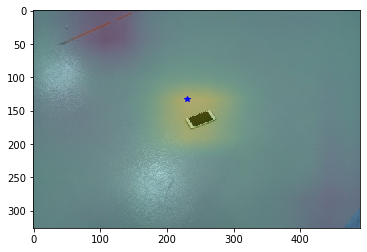

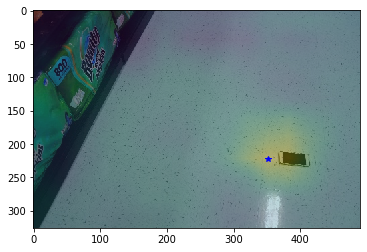

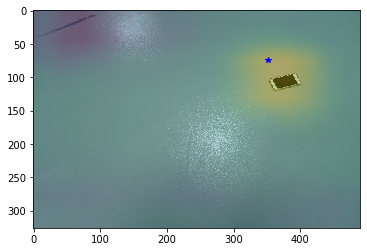

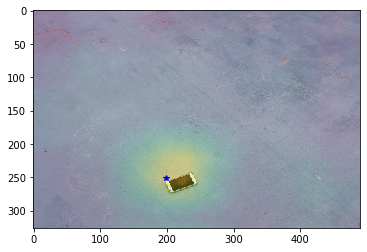

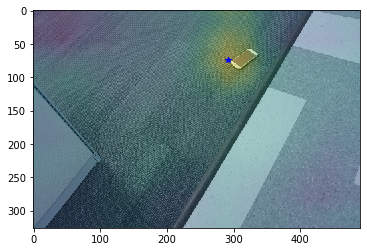

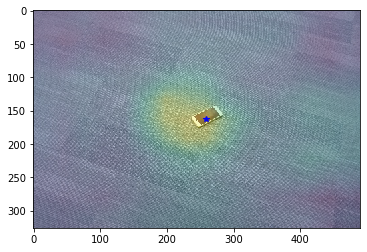

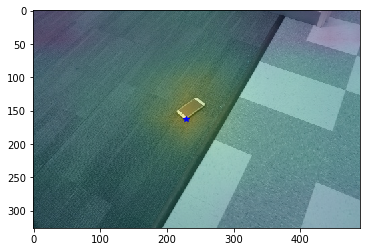

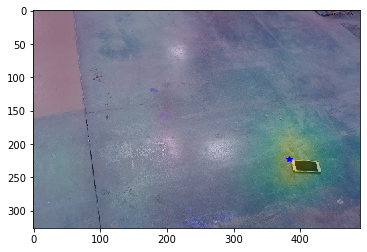

In [11]:
with torch.no_grad():
    for i, sample in enumerate(loader):
        img = sample[0].to(device)
        output = res_last_conv(img)
        img_r = reverse_transform(img.cpu().squeeze())
        am_np=output.squeeze().cpu().numpy()
        am_np_rz=transform.resize(
                am_np,
                img_r.shape[:2])
        x,y=np.unravel_index(am_np_rz.argmax(), am_np_rz.shape)
        plt.imshow(img_r)
        plt.imshow(
            am_np_rz,
            alpha=0.3
        )   
        plt.plot(y,x,'b*')
        plt.show()
